# VacationPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [3]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
from pprint import pprint

# Import API key
from api_keys import g_key

### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [4]:
city_data_df = pd.read_csv('../WeatherPy/city_data.csv')
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,qaanaaq,77.48,-69.36,41.81,65,4,2.04,GL,1595751081
1,butaritari,3.07,172.79,83.34,73,0,18.59,KI,1595751083
2,ushuaia,-54.80,-68.30,28.40,92,75,9.17,AR,1595751085
3,yar-sale,66.83,70.83,60.48,64,100,12.30,RU,1595751087
4,acajutla,13.59,-89.83,71.01,99,100,4.70,SV,1595751089


### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [5]:
gmaps.configure(api_key=g_key)

In [15]:
# Store latitude and longitude in locations
locations = city_data_df[["Lat", "Lng"]]
weights = city_data_df["Humidity"]

# Plot as a Terrain map
fig = gmaps.figure(zoom_level = 2, center = [0,180])

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=weights, dissipating=False, max_intensity=300, point_radius=5)
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

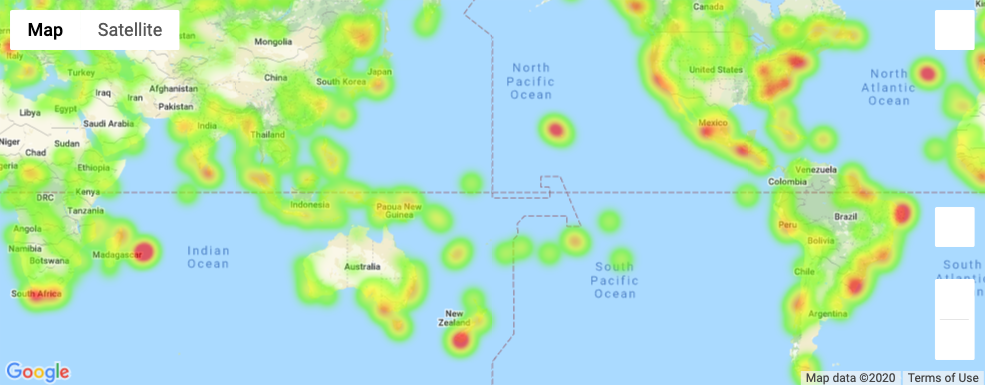

In [16]:
from IPython.display import Image
Image("humidity_map.png")

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [17]:
# Narrow down the cities with Max Temp < 85
ideal_max_temp = city_data_df.loc[city_data_df["Max Temp"] < 85, :]
ideal_temp = ideal_max_temp.loc[ideal_max_temp["Max Temp"] > 65, :]

# Narrow down the cities with Humidity < 60
ideal_humidity = ideal_temp.loc[ideal_temp["Humidity"] < 55, :]

# Narrow down the cities with Ideal Wind Speed < 10
ideal_wind = ideal_humidity.loc[ideal_humidity["Wind Speed"] < 5, :]

# Check the data set length
print(len(ideal_wind))

14


In [18]:
# Check the dataframe
ideal_wind.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
95,saint george,37.10,-113.58,81.00,19,1,4.70,US,1595751286
157,chiredzi,-21.05,31.67,70.50,43,0,1.63,ZW,1595751421
236,puksoozero,62.59,40.61,72.63,40,0,3.76,RU,1595751588
247,magistralnyy,56.17,107.45,70.43,47,100,3.80,RU,1595751612
287,seoul,37.57,126.98,84.20,54,90,2.46,KR,1595751598


### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [19]:
# Grab "City" for finding restaurant
organized_city_df = ideal_wind[["City", "Country", "Lat", "Lng"]]
# Reset Index
organized_city_df = organized_city_df.reset_index(drop=True)
organized_city_df

,City,Country,Lat,Lng
0,saint george,US,37.10,-113.58
1,chiredzi,ZW,-21.05,31.67
2,puksoozero,RU,62.59,40.61
3,magistralnyy,RU,56.17,107.45
4,seoul,KR,37.57,126.98
5,malinovskiy,RU,61.20,62.84
6,teramo,IT,42.65,13.68
7,atasu,KZ,48.68,71.64
8,sokolniki,PL,50.64,21.81
9,zherdevka,RU,51.85,41.46


In [20]:
# set up additional columns to hold information
organized_city_df['Hotel Name'] = ""
organized_city_df['Rating'] = ""
organized_city_df['Address'] = ""
organized_city_df.head()

,City,Country,Lat,Lng,Hotel Name,Rating,Address
0,saint george,US,37.10,-113.58,,,
1,chiredzi,ZW,-21.05,31.67,,,
2,puksoozero,RU,62.59,40.61,,,
3,magistralnyy,RU,56.17,107.45,,,
4,seoul,KR,37.57,126.98,,,


In [21]:
# params dictionary to update each iteration
params = {
    "radius": 5000,
    "types": "lodging",
    "keyword": "lodging",
    "key": g_key
}

# Use the lat/lng to identify hotel
for index, row in organized_city_df.iterrows():
    # get lat, lng from df
    lat = row["Lat"]
    lng = row["Lng"]

    # change location each iteration while leaving original params in place
    params["location"] = f"{lat},{lng}"

    # Use the search term: "International Airport" and our lat/lng
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    # make request and print url
    name_hotel = requests.get(base_url, params=params)
    
    #print the name_address url, avoid doing for public github repos in order to avoid exposing key
    #print(name_hotel.url)

    # convert to json
    name_hotel = name_hotel.json()
    pprint(name_hotel)
    
     # Since some data may be missing we incorporate a try-except to skip any that are missing a data point.
    try:
        organized_city_df.loc[index, "Hotel Name"] = name_hotel["results"][0]["name"]
        organized_city_df.loc[index, "Rating"] = name_hotel["results"][0]["rating"]
        organized_city_df.loc[index, "Address"] = name_hotel["results"][0]["plus_code"]["compound_code"]
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

{'html_attributions': [],
 'next_page_token': 'CrQCJQEAAMH6u4Rx5-18xyUAd3dOcQ-MVqDYjpEzLp0blLCDnQkXqstfnRBmEfV0tq_JA0CGv_yXPIN2NiepvBFS5WGdR3TZp9pbf8BXjfTnOB8HLJop_uWQRvl4Og3bzfqpdRkTlrTOFzsQnQCGNSn4D5PQKBP2-GcwbdgDwzuFLUWHylBf8uQP4tywj2SKPvOtvjvTelo0eOaC4PcNfy9yuB9c50mP8YjBijIoypHH9qEIatRHmoYP4Zej3mgq6173QFEkS_PVvywhMAffypLyDcMZRqiQ2X2uuCJcEiFfal-bA7dXXgJD-H31J5qiAU8IDnDiLqfUYotiONqBB13PBBtYkMHbJpqwWbRZwuZpdqNStjnfzGYzcYzLe8WvhqsGpycVs2Df9VqLXDuz6r1ssImvK3QSEEj0fG9EFJjHfqPa6Qp3CHsaFP5zQfVVl83xWA7L001acc53uL7m',
 'results': [{'business_status': 'OPERATIONAL',
              'geometry': {'location': {'lat': 37.0890245, 'lng': -113.5842669},
                           'viewport': {'northeast': {'lat': 37.09019957989273,
                                                      'lng': -113.5824545},
                                        'southwest': {'lat': 37.08749992010728,
                                                      'lng': -113.5864653}}},
              'icon': 'https://maps.gst

{'html_attributions': [],
 'results': [{'business_status': 'OPERATIONAL',
              'geometry': {'location': {'lat': -21.045465, 'lng': 31.668},
                           'viewport': {'northeast': {'lat': -21.04411432010728,
                                                      'lng': 31.66934742989272},
                                        'southwest': {'lat': -21.04681397989273,
                                                      'lng': 31.66664777010728}}},
              'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/lodging-71.png',
              'id': '3cd5366ff4db23912e8272906453bbe352eea2af',
              'name': 'The Nesbitt Arms',
              'opening_hours': {'open_now': True},
              'photos': [{'height': 4912,
                          'html_attributions': ['<a '
                                                'href="https://maps.google.com/maps/contrib/108323135399903250374">A '
                                                'Google User</a

{'html_attributions': [], 'results': [], 'status': 'ZERO_RESULTS'}
Missing field/result... skipping.
{'html_attributions': [],
 'results': [{'business_status': 'OPERATIONAL',
              'geometry': {'location': {'lat': 42.65819159999999,
                                        'lng': 13.6833765},
                           'viewport': {'northeast': {'lat': 42.65955157989273,
                                                      'lng': 13.68471572989272},
                                        'southwest': {'lat': 42.65685192010729,
                                                      'lng': 13.68201607010728}}},
              'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/lodging-71.png',
              'id': 'b3b0082e4d368e7c5d31847ff0d86ed893225094',
              'name': 'La Casa dei Nonni B&B',
              'photos': [{'height': 2736,
                          'html_attributions': ['<a '
                                                'href="https://maps.google.com

{'html_attributions': [],
 'results': [{'business_status': 'OPERATIONAL',
              'geometry': {'location': {'lat': 48.6885092,
                                        'lng': 71.68794919999999},
                           'viewport': {'northeast': {'lat': 48.68964737989272,
                                                      'lng': 71.68947922989273},
                                        'southwest': {'lat': 48.68694772010728,
                                                      'lng': 71.68677957010728}}},
              'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/lodging-71.png',
              'id': '648d6c9aa168e96a3d182f30ddfd03e0527995b9',
              'name': 'Dostyk',
              'photos': [{'height': 2250,
                          'html_attributions': ['<a '
                                                'href="https://maps.google.com/maps/contrib/101472759790122071634">Нуржан '
                                                'Мусабаев</a>'],
     

{'html_attributions': [],
 'results': [{'business_status': 'OPERATIONAL',
              'geometry': {'location': {'lat': 51.830353, 'lng': 41.493913},
                           'viewport': {'northeast': {'lat': 51.83180242989272,
                                                      'lng': 41.49514967989272},
                                        'southwest': {'lat': 51.82910277010727,
                                                      'lng': 41.49245002010728}}},
              'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/lodging-71.png',
              'id': '6e8851dae762f4d2c0c9ed3088020b746bfec5bb',
              'name': 'Юнона',
              'opening_hours': {'open_now': True},
              'photos': [{'height': 4160,
                          'html_attributions': ['<a '
                                                'href="https://maps.google.com/maps/contrib/115622901008569100367">A '
                                                'Google User</a>'],
      

{'html_attributions': [],
 'results': [{'business_status': 'OPERATIONAL',
              'geometry': {'location': {'lat': -19.5221029, 'lng': 45.4579362},
                           'viewport': {'northeast': {'lat': -19.5207914,
                                                      'lng': 45.45871337989273},
                                        'southwest': {'lat': -19.5260374,
                                                      'lng': 45.45601372010729}}},
              'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/lodging-71.png',
              'id': 'cd75236862a0e75f9bf637fa4a5313e65741ff7c',
              'name': 'Baobab',
              'photos': [{'height': 1200,
                          'html_attributions': ['<a '
                                                'href="https://maps.google.com/maps/contrib/107158849412161552679">Nacho '
                                                'Benvenuty</a>'],
                          'photo_reference': 'CmRaAAAA5x8dVM-pe

In [22]:
organized_city_df.head()

,City,Country,Lat,Lng,Hotel Name,Rating,Address
0,saint george,US,37.10,-113.58,Best Western Plus Abbey Inn,4.6,"3CQ8+J7 St. George, Utah"
1,chiredzi,ZW,-21.05,31.67,The Nesbitt Arms,3.5,"XM39+R6 Chiredzi, Zimbabwe"
2,puksoozero,RU,62.59,40.61,,,
3,magistralnyy,RU,56.17,107.45,Магистраль,4.6,"5FG5+5Q Magistral'nyy, Irkutsk Oblast, Russia"
4,seoul,KR,37.57,126.98,Hanok 24 Guesthouse Gyeongbokgung,4.7,"HXHC+C3 Seoul, South Korea"


In [25]:
# Save Data to csv
organized_city_df.to_csv("Hotel_Output.csv") 

In [26]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in organized_city_df.iterrows()]
locations = organized_city_df[["Lat", "Lng"]]

In [27]:
# Add marker layer ontop of heat map
markers = gmaps.marker_layer(locations, info_box_content=hotel_info)

fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))

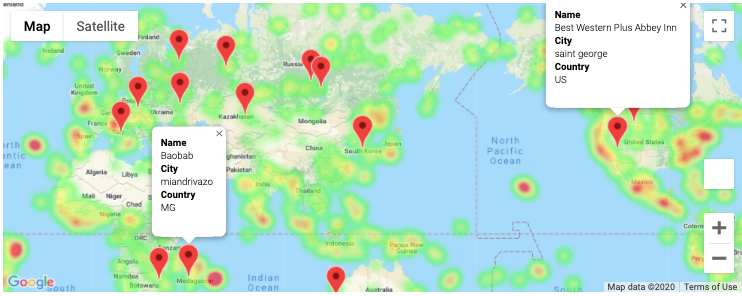

In [28]:
Image("hotel_map.png")